# Задача
Необходимо создать и обучить свёрточную нейроннуюсеть, котораялокализует и  классифицирует только 1 объект на изображении.

### Разделим данную задачу на несколько частей

1. [Предобработка данных](#Предобработка_данных)

2. [Создание и обучение моделей](#Создание_и_обучение_моделей)
 
3. [Проверка моделей](#Проверка_моделей)

### Описание признаков
* **names** - названия файлов
* **target** - класс фотографии (1-кошка, 2-собака)
* **xmin, ymin, xmax, ymax** - bounding box


<a id='Предобработка_данных'></a>
# Предобработка данных



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2
from google.colab.patches import cv2_imshow

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam

Изучим информацию о "GPU".

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10833469656305444993
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11344216064
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7079335699455960512
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [ ]:
train_path = "/content/drive/MyDrive/CV/cats_dogs_dataset/train/"
valid_path = "/content/drive/MyDrive/CV/cats_dogs_dataset/valid/"

Необходимо собрать единую талицу из txt файлов.

In [ ]:
def table(path):
    # Сбор названий всех файлов в папке с разрешением "txt"
    txt_names = []
    for file in os.listdir(path):
        if file.endswith(".txt"):
            txt_names.append(file)

    # Сбор данных из "txt" файлов
    numbers = []
    for txt in txt_names:
        numbers.append(open(path + txt).read())
    
    # Добавление данных в таблицу
    df=pd.DataFrame()

    df['names'] = txt_names
    df['nums'] = numbers
    
    # Разделение колонки с информацией из "txt" на таргет и координаты 
    df[['target', 'xmin', 'ymin', 'xmax', 'ymax']] = df['nums'].str.split(" ",expand=True)

    # Удаление столбца с изначальными данными из "txt"
    df = df.drop(['nums'], axis=1)

    # Замена названий текстовых фалов на фото
    df['names'] = df['names'].str.replace('txt', 'jpg')

    # Перевод данных в нужный формат
    for i in df.columns[1:]:
        df[i] = df[i].astype(int)

    return df

In [ ]:
df_train = table(train_path)
df_valid = table(valid_path)

Убедимся, что данные загрузились корректно.

In [ ]:
df_train.head()

,names,target,xmin,ymin,xmax,ymax
0,staffordshire_bull_terrier_133.jpg,2,141,99,274,235
1,newfoundland_167.jpg,2,223,171,287,242
2,boxer_143.jpg,2,56,32,391,321
3,japanese_chin_182.jpg,2,170,95,374,226
4,scottish_terrier_157.jpg,2,290,48,491,188


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985 entries, 0 to 2984
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   names   2985 non-null   object
 1   target  2985 non-null   int64 
 2   xmin    2985 non-null   int64 
 3   ymin    2985 non-null   int64 
 4   xmax    2985 non-null   int64 
 5   ymax    2985 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 140.0+ KB


In [ ]:
df_valid.head()

,names,target,xmin,ymin,xmax,ymax
0,yorkshire_terrier_101.jpg,2,26,1,373,305
1,scottish_terrier_135.jpg,2,224,20,318,168
2,Maine_Coon_211.jpg,1,86,16,193,135
3,Russian_Blue_183.jpg,1,92,91,243,259
4,Birman_123.jpg,1,191,53,405,226


In [ ]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   names   400 non-null    object
 1   target  400 non-null    int64 
 2   xmin    400 non-null    int64 
 3   ymin    400 non-null    int64 
 4   xmax    400 non-null    int64 
 5   ymax    400 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 18.9+ KB


Посмотрим на несколько фотограий из таблиц с разметкой.



In [ ]:
def photo_check(df, path):
    d_samp = df.sample(3, random_state=42)
    for i in range(len(d_samp)):
        ph = cv2.imread(path+d_samp.iloc[i,0])
        cv2.rectangle(ph, (d_samp.iloc[i,2], d_samp.iloc[i,3]), (d_samp.iloc[i,4], d_samp.iloc[i,5]), (0, 255, 255), 2)
        cv2_imshow(ph)
        print('\n')

Фотографии из тренировочной выборки.

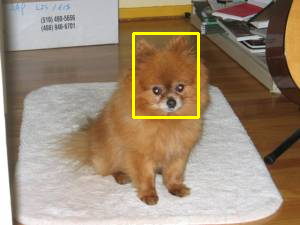

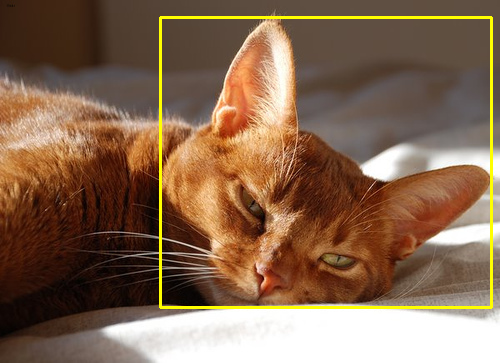

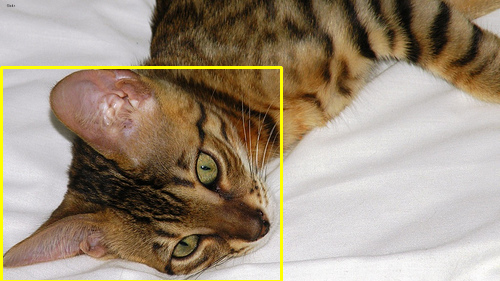

In [ ]:
photo_check(df_train, train_path)

Фотографии из валидационной выборки.

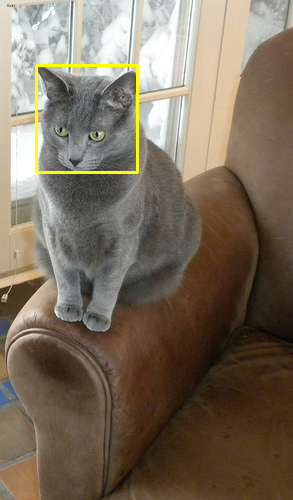

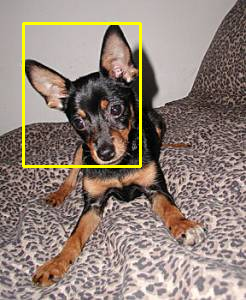

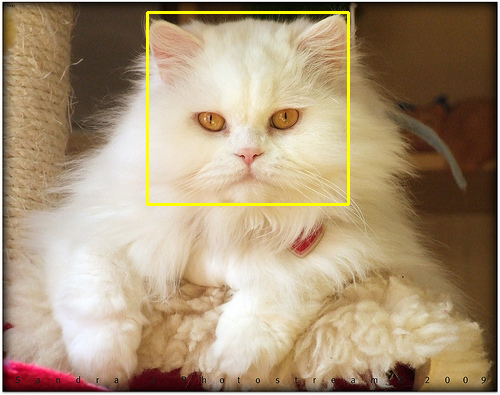

In [ ]:
photo_check(df_valid, valid_path)

Для того, что бы нормализоавть фотографии необходимо перевести координаты bounding box-ов в относительные.

In [ ]:
def coords(df, path):
    
    # Загрузка размеров фотографий

    shapes = []
    for s in df['names']:
        shapes.append(Image.open(path+s).size)

    df[['width', 'heigh']] = shapes

    # Перевод координат в относительные
   
    df['xmin'] = df['xmin'] / df['width']
    df['xmax'] = df['xmax'] / df['width']
    df['ymin'] = df['ymin'] / df['heigh']
    df['ymax'] = df['ymax'] / df['heigh']

    df = df.drop(['width', 'heigh'], axis=1)

    return df 

In [ ]:
df_train = coords(df_train, train_path)
df_valid = coords(df_valid, valid_path)

Заменим разметку в таблицах.

In [ ]:
df_train['target'] =  df_train['target'].astype('object').replace(1,'cat').replace(2,'dog')
df_valid['target'] =  df_valid['target'].astype('object').replace(1,'cat').replace(2,'dog')

Для того, что бы повторно не проводить предобработку данных, сохраним таблицы в формате 'csv'. 

In [ ]:
#df_train.to_csv('/content/drive/MyDrive/CV/cats_dogs_dataset/df_train_cat_dog.csv', index=False)
#df_valid.to_csv('/content/drive/MyDrive/CV/cats_dogs_dataset/df_valid_cat_dog.csv', index=False)

In [ ]:
 df_train = pd.read_csv('/content/drive/MyDrive/CV/cats_dogs_dataset/df_train_cat_dog.csv')
 df_valid = pd.read_csv('/content/drive/MyDrive/CV/cats_dogs_dataset/df_valid_cat_dog.csv')

In [ ]:
df_valid

<a id='Создание_и_обучение_моделей'></a>
# Создание и обучение моделей

Для выполнения задачи я создам 2 модели. Первая сверточная нейросеть будет предсказывать координаты bounding box-a. Вторая модель будет предсказывать класс фотографии.

In [ ]:
WIDTH = 224
HEIGHT = 224

datagen = ImageDataGenerator(rescale=1./255)
          

train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_path,
    x_col='names',
    y_col=['xmin', 'ymin', 'xmax', 'ymax'],
    target_size=(WIDTH, HEIGHT),
    class_mode="raw",
    barch_size=32,
    shuffle=True,
    seed=12345)

valid_datagen_flow = datagen.flow_from_dataframe(
    dataframe=df_valid,
    directory=valid_path,
    x_col='names',
    y_col=['xmin', 'ymin', 'xmax', 'ymax'],
    target_size=(HEIGHT, WIDTH),
    class_mode="raw",
    barch_size=32,
    shuffle=True,
    seed=12345)

Found 2985 validated image filenames.
Found 400 validated image filenames.


In [ ]:
features, target = next(train_datagen_flow)
v_features, v_target = next(valid_datagen_flow)

In [ ]:
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential

In [ ]:
optimizer = Adam(lr=0.001) 

model = Sequential()

model.add(Conv2D(16, (5,5), activation='relu', input_shape=(HEIGHT, WIDTH, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (5,5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(64, (5,5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    
model.add(Conv2D(128, (5,5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(256, (5,5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='sigmoid'))

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 224, 224, 16)      1216      
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 108, 108, 32)      12832     
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 50, 50, 64)        51264     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 21, 21, 128)     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.compile(optimizer=optimizer, loss='mse', metrics=['acc'])

Расчитаем минимальное количество шагов для обучение модели.

In [ ]:
STEP_SIZE_TRAIN = int(np.ceil(train_datagen_flow.n / train_datagen_flow.batch_size))
STEP_SIZE_VAL = int(np.ceil(valid_datagen_flow.n / valid_datagen_flow.batch_size))

print("Тренировочная выборка:", STEP_SIZE_TRAIN)
print("Валидационная выборка:", STEP_SIZE_VAL)

train_datagen_flow.reset()
valid_datagen_flow.reset()

In [ ]:
history = model.fit_generator(train_datagen_flow, validation_data=valid_datagen_flow, 
                    epochs=25, steps_per_epoch=94, validation_steps=13, verbose=2)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
94/94 - 27s - loss: 0.0248 - acc: 0.7039 - val_loss: 0.0204 - val_acc: 0.7250
Epoch 2/25
94/94 - 25s - loss: 0.0215 - acc: 0.7209 - val_loss: 0.0198 - val_acc: 0.7250
Epoch 3/25
94/94 - 25s - loss: 0.0212 - acc: 0.7209 - val_loss: 0.0198 - val_acc: 0.7250
Epoch 4/25
94/94 - 24s - loss: 0.0195 - acc: 0.7223 - val_loss: 0.0158 - val_acc: 0.7300
Epoch 5/25
94/94 - 24s - loss: 0.0162 - acc: 0.7380 - val_loss: 0.0140 - val_acc: 0.7875
Epoch 6/25
94/94 - 24s - loss: 0.0145 - acc: 0.7494 - val_loss: 0.0123 - val_acc: 0.7825
Epoch 7/25
94/94 - 24s - loss: 0.0129 - acc: 0.7675 - val_loss: 0.0141 - val_acc: 0.8050
Epoch 8/25
94/94 - 24s - loss: 0.0116 - acc: 0.7806 - val_loss: 0.0123 - val_acc: 0.8150
Epoch 9/25


Для оценки качества предсказаний я воспользуюсь метрикой 'IOU'(Intersection Over Union).

In [ ]:
import tensorflow as tf
import torch

In [ ]:
def intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    Aarea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    Barea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(Aarea + Barea - interArea)

    return iou

In [ ]:
li = df_valid.iloc[1:,2:].values
pred = model.predict(valid_datagen_flow)

score = []

for i in range(len(li)):   
    score.append(intersection_over_union(li[i], pred[i]))

In [ ]:
np.mean(score)

0.6701394238484393

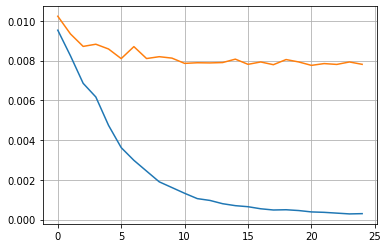

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)

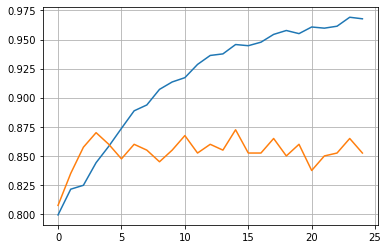

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.grid(True)

Создадим 2 модель для предсказания класса. Для более точного результата я увеличу выборку добавив отзеркаленные фотографии, а так же поворот фотографий.

In [ ]:
c_datagen = ImageDataGenerator(rescale=1./255,
                             horizontal_flip=True, 
                             rotation_range=15,
                             width_shift_range=0.2,
                             height_shift_range=0.2)

c_train_datagen_flow = c_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_path,
    x_col='names',
    y_col='target',
    target_size=(WIDTH, HEIGHT),
    shuffle=True,
    batch_size=32,
    class_mode="categorical",
    seed=12345)

c_valid_datagen_flow = c_datagen.flow_from_dataframe(
    dataframe=df_valid,
    directory=valid_path,
    x_col='names',
    y_col='target',
    target_size=(HEIGHT, WIDTH),
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    seed=12345)

Found 2985 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


In [ ]:
class_model = Sequential()

class_model = Sequential()
class_model.add(VGG16(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, 3)))
class_model.add(Flatten())
class_model.add(Dense(128, activation="relu"))
class_model.add(Dense(64, activation="relu"))
class_model.add(Dense(64, activation="relu"))
class_model.add(Dense(2, activation="sigmoid"))

class_model.layers[-6].trainable = False

class_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 130       
Total params: 17,938,626
Trainable params: 3,223,938
No

In [ ]:
class_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
class_hist = class_model.fit_generator(c_train_datagen_flow, validation_data=c_valid_datagen_flow, epochs=10, steps_per_epoch=94, validation_steps=13, verbose=2)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
94/94 - 80s - loss: 1.0856 - acc: 0.7611 - val_loss: 0.2640 - val_acc: 0.8925
Epoch 2/10
94/94 - 60s - loss: 0.2553 - acc: 0.8911 - val_loss: 0.2770 - val_acc: 0.8875
Epoch 3/10
94/94 - 60s - loss: 0.2375 - acc: 0.8975 - val_loss: 0.1551 - val_acc: 0.9350
Epoch 4/10
94/94 - 60s - loss: 0.2326 - acc: 0.8995 - val_loss: 0.1945 - val_acc: 0.9025
Epoch 5/10
94/94 - 60s - loss: 0.1992 - acc: 0.9162 - val_loss: 0.1945 - val_acc: 0.9175
Epoch 6/10
94/94 - 61s - loss: 0.1906 - acc: 0.9193 - val_loss: 0.1953 - val_acc: 0.9175
Epoch 7/10
94/94 - 61s - loss: 0.1764 - acc: 0.9290 - val_loss: 0.2138 - val_acc: 0.9125
Epoch 8/10
94/94 - 60s - loss: 0.1667 - acc: 0.9266 - val_loss: 0.1845 - val_acc: 0.9250
Epoch 9/10
94/94 - 60s - loss: 0.1671 - acc: 0.9343 - val_loss: 0.1648 - val_acc: 0.9225
Epoch 10/10
94/94 - 60s - loss: 0.1637 - acc: 0.9313 - val_loss: 0.1957 - val_acc: 0.9325


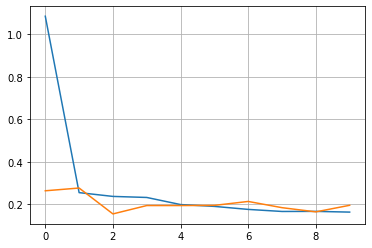

In [ ]:
plt.plot(class_hist.history['loss'])
plt.plot(class_hist.history['val_loss'])
plt.grid(True)

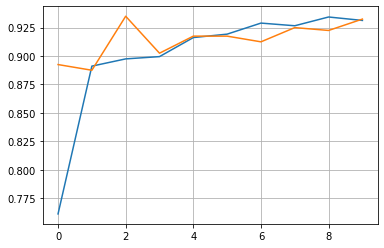

In [ ]:
plt.plot(class_model.history.history['acc'])
plt.plot(class_model.history.history['val_acc'])
plt.grid(True)

In [ ]:
def image_pred(name):
    
    true_box = round(df_valid[df_valid['names']==name].iloc[:,2:]*224)

    img = cv2.resize(cv2.imread('/content/drive/MyDrive/CV/cats_dogs_dataset/valid/'+name) / 255.0, dsize=(WIDTH, HEIGHT))
    box_pred = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH
    label = class_model.predict(img.reshape(1, WIDTH, HEIGHT, 3))

    for i in label:
        if i[0] > i[1]:
            label = 'cat'
        else:
            label = 'dog'
            
    xt, yt = box_pred[0], box_pred[1]
    xb, yb = box_pred[2], box_pred[3]

    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    t_image = cv2.rectangle(img, (int(true_box['xmin']), int(true_box['ymin'])), (int(true_box['xmax']), int(true_box['ymax'])), (0, 255, 0), 2)
    p_image = cv2.rectangle(t_image, (xt, yt), (xb, yb), (0, 255, 255), 2)
    image = cv2.putText(p_image, label, (180, 220),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    plt.imshow(p_image)
    plt.axis('off')
    plt.show()

Russian_Blue_146.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


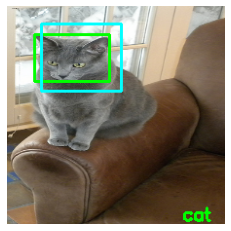

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


miniature_pinscher_119.jpg


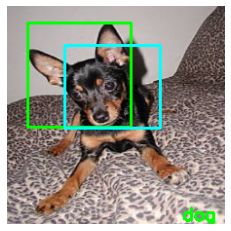

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Persian_161.jpg


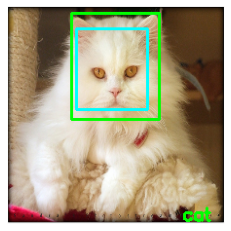

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Bengal_167.jpg


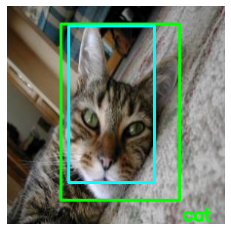

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Bengal_174.jpg


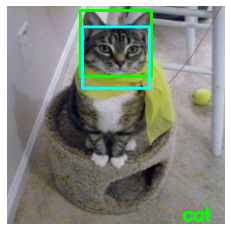

In [ ]:
for i in df_valid['names'].sample(5, random_state=42):
    print(i)
    image_pred(i)

In [ ]:
def photo_pred(path):
    img = cv2.resize(cv2.imread(path) / 255.0, dsize=(WIDTH, HEIGHT))
    y_hat = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH
   
    xt, yt = y_hat[0], y_hat[1]
    xb, yb = y_hat[2], y_hat[3]

    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 255, 255), 2)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


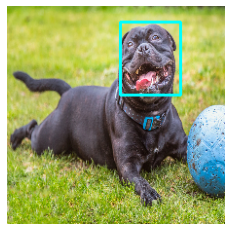

In [ ]:
photo_pred('/content/drive/MyDrive/CV/1800x1200_dog_cool_summer_other (2).jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


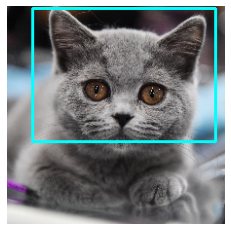

In [ ]:
photo_pred('/content/drive/MyDrive/CV/square_1280_7efc59cef497ea4709ca7c66021763cb.jpg')